# Optimización de Código en Python

## Objetivo

Demostrar cómo mejorar el rendimiento computacional en Python mediante tres enfoques distintos de optimización numérica:

- Bucles nativos (Python puro).
- Vectorización con NumPy.
- Compilación Just-In-Time (JIT) con Numba.
- Medición de rendimiento usando context managers personalizados y timeit.

## Creación de contextmanager y funciones

Se define un context manager llamado timer que permite medir el tiempo de ejecución de un bloque de código.
Usa time.perf_counter(), que proporciona mayor precisión que time.time().

La elección de las técnicas a comparar esta basada en que cada una tiene diferentes caracteristicas al momento de hacer calculos:
- Bucles: Simplicidad y claridad inicial, casos muy simples o didácticos .
- Numpy: Gran velocidad sin necesidad de compilar, operaciones con arrays grandes.
- Numba: Máxima velocidad con mínima modificación de código, cálculos numéricos intensivos con lógica repetitiva.

Las tres técnicas fueron usadas como funciones a las que se les entrega dos arreglos:
- Bucles de python: se uso un bucle "for" normal, utilizando "zip" para iterar sobre ambos arreglos.
- Vectorización con NumPy: se utiliza la potencia de la vectorización de NumPy para realizar la operación en una sola línea.
- Función optimizada con Numba: se usa decorador @jit(nopython=True) para compilar la función a código máquina usando Numba, de modo que, aunque se utiliza un bucle for, esta optimizado para mejorar considerablemente la velocidad.

In [ ]:
# Importar las librerías necesarias
import numpy as np
import time
from contextlib import contextmanager
from numba import jit
import matplotlib.pyplot as plt
import timeit

# Context manager para medir el tiempo de ejecución usando time.perf_counter que es mas preciso que time.time
@contextmanager
def timer(caso, tiempos=None):
    inicio = time.perf_counter()
    yield
    fin = time.perf_counter()
    duracion = fin - inicio
    if tiempos is not None:
        tiempos[caso] = duracion

# 1. Función con bucles nativos 
def suma_de_productos_bucles(arr1, arr2):
    # Revisamos que los arreglos tengan el mismo tamaño
    if len(arr1) != len(arr2):
        raise ValueError("Los arreglos deben tener igual tamaño")
    # Se comienza con 0 para inicializar la variable de resultado
    resultado = 0
    # Se usa zip para iterar sobre ambos arreglos simultáneamente
    for a, b in zip(arr1, arr2):
        resultado += a * b
    return resultado

# 2. Función vectorizada con NumPy
def suma_de_productos_numpy(arr1, arr2):
    return np.sum(arr1 * arr2)

# 3. Función optimizada con Numba, el decorador @jit(nopython=True) obliga a no usar el intérprete de Python.
@jit(nopython=True)
def suma_de_productos_numba(arr1, arr2):
    resultado = 0
    for i in range(arr1.shape[0]):
        resultado += arr1[i] * arr2[i]
    return resultado

## Implementación de las funciones

Se generan dos arreglos grandes (arreglo1 y arreglo2) de 10 millones de números aleatorios cada uno. Estos datos sirven para probar y comparar el rendimiento de las distintas implementaciones bajo condiciones realistas y computacionalmente intensivas.

Se realiza un "warm-up" para numba utilizando la función optimizada con Numba una vez antes de medir los tiempos, esto es debido a que, si no se hace, el compilador JIT de Numba puede incluir el tiempo de compilación en las mediciones posteriores. Es importante porque la primera ejecución con Numba suele ser más lenta debido a esta compilación inicial.

Se usa el context manager timer para medir el tiempo que tarda cada función en procesar los arreglos generados.Cada bloque with timer(...) ejecuta una función y registra su tiempo de ejecución en el diccionario "tiempos".

Se valida que los resultados de las tres funciones sean equivalentes dentro de una tolerancia numérica, usando "np.allclose".Esta validación es crucial para asegurar que las optimizaciones no afectaron la precisión del cálculo.

Finalmente, se imprimen los tiempos obtenidos para cada técnica, mostrando el rendimiento en segundos, además de graficar las comparaciones.


Tiempos individuales (una sola ejecución con context manager):
Bucles nativos de Python: 1.489292 segundos
Vectorización con NumPy: 0.030433 segundos
Optimización con Numba: 0.010329 segundos


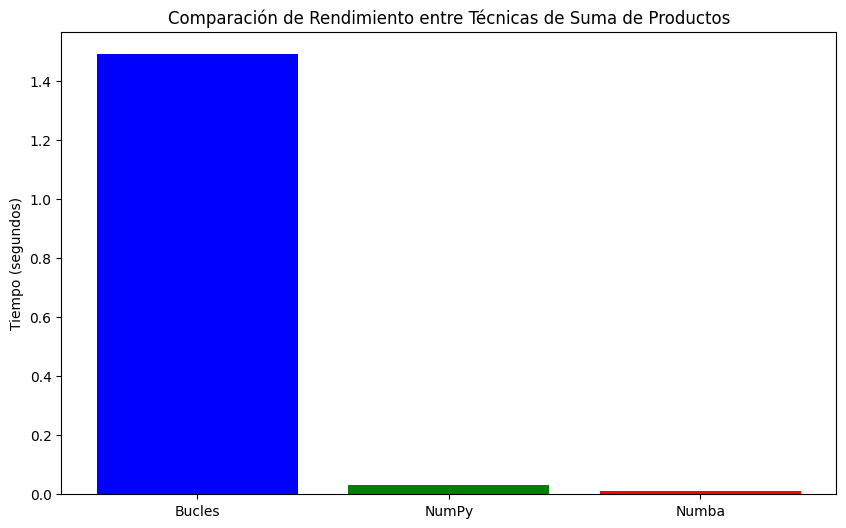

In [16]:
# Generar datos de prueba (genera dos arrays grandes de 10 millones de números aleatorios)
tamaño = 10_000_000
arreglo1 = np.random.rand(tamaño)
arreglo2 = np.random.rand(tamaño)

# Warm-up con los mismos datos grandes que vas a usar
suma_de_productos_numba(arreglo1, arreglo2)

# Medición con context manager para los 3 casos
tiempos = {}
with timer("Bucles nativos de Python", tiempos):
    resultado_bucles = suma_de_productos_bucles(arreglo1, arreglo2)

with timer("Vectorización con NumPy", tiempos):
    resultado_numpy = suma_de_productos_numpy(arreglo1, arreglo2)

with timer("Optimización con Numba", tiempos):
    resultado_numba = suma_de_productos_numba(arreglo1, arreglo2)

# Validación de resultados, se asegura que los resultados de las tres funciones sean similares
assert np.allclose(resultado_bucles, resultado_numpy)
assert np.allclose(resultado_numpy, resultado_numba)

# Mostrar los resultados de los tiempos de ejecución
print("\nTiempos individuales (una sola ejecución con context manager):")
for caso, duracion in tiempos.items():
    print(f"{caso}: {duracion:.6f} segundos")

# Gráfico con datos de timeit
comparacion_tiempos = {
    'Bucles': tiempos["Bucles nativos de Python"],
    'NumPy': tiempos["Vectorización con NumPy"],
    'Numba': tiempos["Optimización con Numba"]
}

# Se crea un gráfico de barras para comparar los tiempos de ejecución y lo guarda como png
plt.figure(figsize=(10, 6))
plt.bar(comparacion_tiempos.keys(), comparacion_tiempos.values(), color=['blue', 'green', 'red'])
plt.ylabel('Tiempo (segundos)')
plt.title('Comparación de Rendimiento entre Técnicas de Suma de Productos')
plt.savefig('comparacion_rendimiento.png')
plt.show()

## Comparación de mediciones de tiempo entre las tres técnicas usando mas de una repeticion

Esta parte es principalmente una forma de estandarizar los tiempos, ya que a pesar de hacer un calentamiento para numba, algun proceso del sistema podria alterar la primera medición de los tiempos de cada técnica, por lo que se decidió hacer una comparación extra usando un promedio entre 5 mediciones para cada caso usando "timeit.repeat", que permite ejecutar cada función varias veces.

Igual que anteriormente, se imprimieton los resultados de tiempo promedio para cada caso y se graficaron.

Comparación con timeit (promedio de 5 ejecuciones):
Bucles Python: 1.468615 s (promedio)
Vectorización NumPy: 0.030069 s (promedio)
Numba JIT: 0.010575 s (promedio)


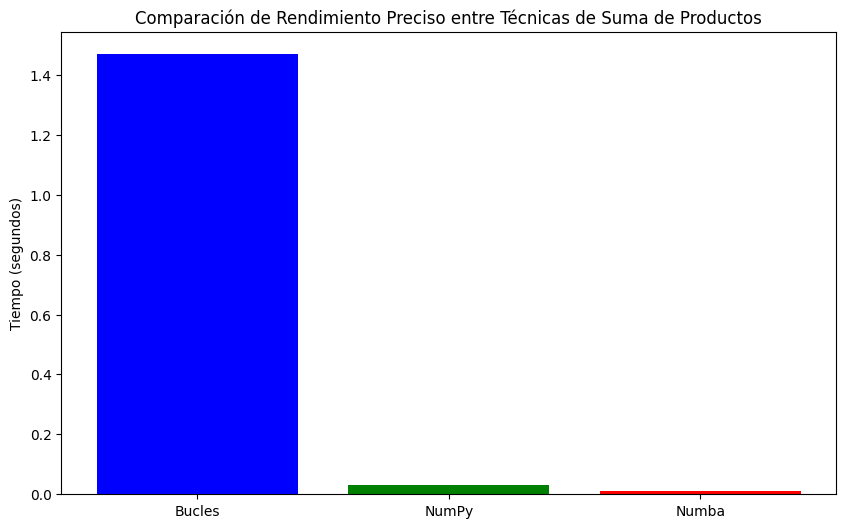

In [ ]:
# Comparación preciso con timeit, se mide el tiempo de ejecución con más precisión y se calcula el promedio de 5 ejecuciones.
# Se usa lambda para encapsular la llamada a la función y evitar que se ejecute inmediatamente.
print("Comparación con timeit (promedio de 5 ejecuciones):")
tiempos_bucles = timeit.repeat(lambda: suma_de_productos_bucles(arreglo1, arreglo2), number=1, repeat=5)
tiempos_numpy = timeit.repeat(lambda: suma_de_productos_numpy(arreglo1, arreglo2), number=1, repeat=5)
tiempos_numba = timeit.repeat(lambda: suma_de_productos_numba(arreglo1, arreglo2), number=1, repeat=5)

# Calcular promedios
promedio_bucles = np.mean(tiempos_bucles)
promedio_numpy = np.mean(tiempos_numpy)
promedio_numba = np.mean(tiempos_numba)

print(f"Bucles Python: {promedio_bucles:.6f} s (promedio)")
print(f"Vectorización NumPy: {promedio_numpy:.6f} s (promedio)")
print(f"Numba JIT: {promedio_numba:.6f} s (promedio)")

# Gráfico con datos de timeit
tiempos_timeit = {
    'Bucles': promedio_bucles,
    'NumPy': promedio_numpy,
    'Numba': promedio_numba
}

# Se crea un gráfico de barras para comparar los tiempos de ejecución y lo guarda como png
plt.figure(figsize=(10, 6))
plt.bar(tiempos_timeit.keys(), tiempos_timeit.values(), color=['blue', 'green', 'red'])
plt.ylabel('Tiempo (segundos)')
plt.title('Comparación de Rendimiento Preciso entre Técnicas de Suma de Productos')
plt.savefig('comparacion_rendimiento_promedio.png')
plt.show()

### Interpretación y Conclusión

- Los **bucles nativos** son los más lentos debido a la ejecución secuencial y la sobrecarga del intérprete de Python.
- **NumPy** ofrece una mejora sustancial al usar operaciones vectorizadas.
- **Numba** supera incluso a NumPy al compilar directamente a código máquina, ideal para operaciones simples pero repetitivas.

Este ejercicio muestra cómo, partiendo de una solución básica, se pueden aplicar herramientas especializadas (NumPy, Numba) para obtener mejoras de rendimiento muy significativas, especialmente en tareas de procesamiento numérico intensivo como es el caso de la suma de productos de dos arreglos grandes.